In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [2]:
from components.general_operations import GeneralOp
from components.replication import Replication
from components.tampering import Tampering


# general = GeneralOp()
replication =  Replication()
# tampering = Tampering()

### General operation

In [3]:

class GeneralOp:
    def __init__(self):
        pass

    def print_statistics(self,df):
        print("Number of samples : "+str(len(df['serviceid'].unique())))
        print("Number of uniques providers : "+str(len(df['providerid'].unique())))
        print("Number of microcells:"+str(len(df['microcell'].unique())))

    def open_file(self,file_name):
        return pd.read_excel(file_name)
    
    def open_file_csv(self,file_name):
        return pd.read_csv(file_name)
    
    def save_file(self,df,file_name):
        df.to_excel(file_name)

    def slice_df(self,df,fields):
        return df[fields]

    def dataframe_devide_to_microcell_dictionary(self,df):
        temp_dictionary={}
        unique_keys = df.microcell.unique()
        for microcell in unique_keys:
            temp_dictionary["{}".format(microcell)] = df[df.microcell==microcell]
        return temp_dictionary

    def trust_score_calculation(self,datain,weight_matrix):
        scores={}
        for k in datain.keys():
            wifi_df = datain[k]
            wifi_df = wifi_df.reset_index(drop=True)
            list1=[]
            for i in range(0,wifi_df.shape[0]): 					
                list1.append(((wifi_df['speed'][i]*weight_matrix[0])+(wifi_df['latency'][i]*weight_matrix[1])+(wifi_df['bandwidth'][i]*weight_matrix[2])+(wifi_df['coverage'][i]*weight_matrix[3])+(wifi_df['reliability'][i]*weight_matrix[4])+(wifi_df['security'][i]*weight_matrix[5]))/10)
            wifi_df['TS'] = list1
            scores[k] = wifi_df
        return scores
    
    def add_a_column_with_a_value(self,df,name,val):
        df[name] = val
        return df
    
    def dictionary_to_merged_df(self,dic):
        temp = pd.concat(dic.values(), ignore_index=True)
        temp.reset_index(drop=True, inplace=True)
        return temp
    
    def visualize_data_one_value(self,df_dic):
        vis_list = []
        for k in df_dic.keys():
            vis_list.append([k,df_dic[k]['TS'].mean()])
        cities = [item[0] for item in vis_list]
        values = [item[1] for item in vis_list]
        plt.figure(figsize=(10, 6))
        plt.scatter(cities, values)
        plt.title('Trust scores for Microcells')
        plt.xlabel('Microcells')
        plt.ylabel('Trust scores')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def visualize_data_two_values(self,df_dic,df_tam_dic):
        vis_list_add = []
        for k in df_dic.keys():
            vis_list_add.append([k,df_dic[k]['TS'].mean(),df_tam_dic[k]['TS'].mean()])

        # Extracting city names and values from the data list
        cities = [item[0] for item in vis_list_add]
        values1 = [item[1] for item in vis_list_add]
        values2 = [item[2] for item in vis_list_add]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(cities, values1)
        plt.scatter(cities, values2)
        plt.title('Trust scores for Microcells')
        plt.xlabel('Microcells')
        plt.ylabel('Trust scores')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()
        plt.show()


general = GeneralOp()

In [4]:
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler


class Sophistication:
    def __init__(self):
        pass

    def detect_sophistication(self, correct_data, tampered_data, weight):
        results_review = {}
        print(tampered_data)
        df_sct = general.dictionary_to_merged_df(tampered_data)
        df_sct = df_sct[df_sct['label'] == 'T']
        tampered_data = general.dataframe_devide_to_microcell_dictionary(df_sct)

        for key2, df2 in tampered_data.items():
            df2_received = df2[(df2['label'] == 'T') & (df2['origin'] == 'R')]
            df2_generated = df2[(df2['label'] == 'T') & (df2['origin'] == 'G')]

            if not df2_received.empty:
                df2_received = self._process_received_data(df2_received, correct_data)

            if not df2_generated.empty:
                df2_generated = self._process_generated_data(df2_generated, correct_data, key2)

            combined_microcell_df = pd.concat([df2_generated, df2_received])
            combined_microcell_df = combined_microcell_df[combined_microcell_df['D_speed'] != 'NC']
            combined_microcell_df = combined_microcell_df[(combined_microcell_df['speed'] != 0) &
                                        (combined_microcell_df['latency'] != 0) &
                                        (combined_microcell_df['bandwidth'] != 0) &
                                        (combined_microcell_df['coverage'] != 0) &
                                        (combined_microcell_df['reliability'] != 0) &
                                        (combined_microcell_df['security'] != 0)]
            combined_microcell_df=combined_microcell_df.reset_index(drop=True)
            nc_count = combined_microcell_df['D_speed'].value_counts().get('NC', 0)
            total_count = len(combined_microcell_df['D_speed'])

            print("Microcell:", key2)
            print("Count of 'NC':", nc_count)
            print("Total count:", total_count)

            results_review[key2] = combined_microcell_df
        print("*********second part************")
        out_data={}
        for key, df in results_review.items():
            df=df.reset_index(drop=True)
            
            sample_list =[]

            impact = self._calculate_impact(df, weight)
            sig = self._calculate_significance(df, weight)
            trend = self._calculate_trend(df,correct_data)
            data = {'Impact': impact, 'Significance': sig, 'Trend': trend}

            new_df = pd.DataFrame(data)
            new_df = new_df[new_df['Trend'] != 'NC']
            new_df=new_df.reset_index(drop=True)
            print(key,new_df.shape[0])
            out_data[key] = new_df
            # print(new_df)
            # results_review[key2]= new_df

        return out_data

    def _process_received_data(self, df_received, correct_data):
        for i, row in df_received.iterrows():
            origin_record = correct_data[correct_data['serviceid'] == row['serviceid']]
            for attr in ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']:
                df_received.at[i, f'D_{attr}'] = origin_record[attr].values[0] if not origin_record.empty else 'NC'
        return df_received

    def _process_generated_data(self, df_generated, correct_data, key2):
        for i, row in df_generated.iterrows():
            provider_other_df = correct_data[(correct_data['providerid'] == row['providerid']) & (correct_data['microcell'] != key2)]
            if len(provider_other_df) > 1:
                mean_values = provider_other_df[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']].mean()
                df_generated.loc[i, 'D_speed':'D_security'] = mean_values.values
            else:
                df_generated.loc[i, 'D_speed':'D_security'] = 'NC'
        return df_generated
    def _calculate_impact(self, df_row, weight):
        d_speed = df_row['speed'] - df_row['D_speed']
        d_latency = df_row['latency'] - df_row['D_latency']
        d_bandwidth = df_row['bandwidth'] - df_row['D_bandwidth']
        d_coverage = df_row['coverage'] - df_row['D_coverage']
        d_reliability = df_row['reliability'] - df_row['D_reliability']
        d_security = df_row['security'] - df_row['D_security']

        impact = (d_speed * weight[0] + d_latency * weight[1] + d_bandwidth * weight[2] +
                d_coverage * weight[3] + d_reliability * weight[4] + d_security * weight[5]).div(5)
        impact = impact.clip(lower=0)
        return impact

    def _calculate_significance(self, df_row, weight1):
        power = 1  # You can adjust this power value to enhance the weights of higher values
        powered_matrix = [x ** power for x in weight1]
        total_sum = sum(powered_matrix)
        weight = [x / total_sum for x in powered_matrix]
        print(weight)
        sig_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                sig_list.append(0)
            else:
                percent_speed = (df_row.iloc[i]['speed'] - df_row.iloc[i]['D_speed'])
                percent_latency = (df_row.iloc[i]['latency'] - df_row.iloc[i]['D_latency'])
                percent_bandwidth = (df_row.iloc[i]['bandwidth'] - df_row.iloc[i]['D_bandwidth'])
                percent_coverage = (df_row.iloc[i]['coverage'] - df_row.iloc[i]['D_coverage'])
                percent_reliability = (df_row.iloc[i]['reliability'] - df_row.iloc[i]['D_reliability'])
                percent_security = (df_row.iloc[i]['security'] - df_row.iloc[i]['D_security'])
                num_changed = sum(abs(percent_change) > 0 for percent_change in
                  [percent_speed, percent_latency, percent_bandwidth, percent_coverage,
                   percent_reliability, percent_security])
                
                significance =  (1 if percent_speed > 0 else 0)  * weight[0] + \
                            (1 if percent_latency > 0 else 0)   * weight[1] + \
                            (1 if percent_bandwidth > 0 else 0)  * weight[2] + \
                            (1 if percent_coverage > 0 else 0)  * weight[3] + \
                            (1 if percent_reliability > 0 else 0)  * weight[4] + \
                            (1 if percent_security > 0 else 0) * weight[5]
                
                # significance =  percent_speed  * weight[0] + \
                #             percent_latency  * weight[1] + \
                #             percent_bandwidth * weight[2] + \
                #             percent_coverage * weight[3] + \
                #             percent_reliability * weight[4] + \
                #             percent_security* weight[5]

                
                significance = max(significance,0)
                sig_list.append((significance) / num_changed)
           
                
        return sig_list

    def _calculate_trend(self, df_row, dfcorrect):
        trend_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                trend_list.append(0)
            else:
                temp_df = dfcorrect[dfcorrect['providerid'] == df_row.iloc[i]['providerid']]
                temp_df = temp_df[temp_df['serviceid'] != df_row.iloc[i]['serviceid']]
                if temp_df.shape[0] > 0:
                    s_mean = temp_df['speed'].mean()
                    l_mean = temp_df['latency'].mean()
                    b_mean = temp_df['bandwidth'].mean()
                    c_mean = temp_df['coverage'].mean()
                    r_mean = temp_df['reliability'].mean()
                    sec_mean = temp_df['security'].mean()

                    s_trend = df_row.iloc[i]['speed'] - s_mean
                    l_trend = df_row.iloc[i]['latency'] - l_mean
                    b_trend = df_row.iloc[i]['bandwidth'] - b_mean
                    c_trend = df_row.iloc[i]['coverage'] - c_mean
                    r_trend = df_row.iloc[i]['reliability'] - r_mean
                    sec_trend = df_row.iloc[i]['security'] - sec_mean
                    normalized_s_trend = self._normalize_trend(s_trend)
                    normalized_l_trend = self._normalize_trend(l_trend)
                    normalized_b_trend = self._normalize_trend(b_trend)
                    normalized_c_trend = self._normalize_trend(c_trend)
                    normalized_r_trend = self._normalize_trend(r_trend)
                    normalized_sec_trend = self._normalize_trend(sec_trend)

                    total_trend = (normalized_s_trend + normalized_l_trend + normalized_b_trend +
                                normalized_c_trend + normalized_r_trend + normalized_sec_trend) / 6
                    total_trend = max(total_trend,0)
                else:
                    total_trend = 'NC'
                trend_list.append(total_trend)
           
                
        return trend_list

    def _normalize_trend(self, trend_value):
        min_value = 0
        max_value = 5
        score = 1 - (trend_value - min_value) / (max_value - min_value)
        return max(0, min(score, 1))
 

   


sophistication = Sophistication()


In [5]:
class Tampering:
    def __init__(self):
        pass
    def tamper_data1(self, data, sp_percent, type, each_attribute=10, val=5,sig=[0.3,0.1,0.2,0.1,0.1,0.2]):
        sp_amount = len(data) * (sp_percent / 100)
        sampled_keys = random.sample(list(data.keys()), round(sp_amount))
        tampered_data = {}


        for key in sampled_keys:
            df = data[key]
            dftamper = df.copy()
            dftamper=dftamper.reset_index(drop=True)
            if type == "N1":
                if not dftamper.empty:
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = 4.8
                    dftamper['true_label'] = 'T'
            elif type == "N2":
                if not dftamper.empty:
                    num_rows_to_tamper = int(0.5 * len(dftamper))
                    rows_to_tamper = np.random.choice(dftamper.index, num_rows_to_tamper, replace=False)
                    dftamper.loc[rows_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = 4.8
                    dftamper.loc[rows_to_tamper, 'true_label'] = 'T'

            elif type == "K1":
                if not dftamper.empty:
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] *= (1 + (each_attribute / 100))
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = np.minimum(dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']], val)
                    dftamper['true_label'] = 'T'

            elif type == "K2":
                if not dftamper.empty:
                    unique_providers = dftamper['providerid'].unique()
                    num_providers_to_tamper = int(0.5 * len(unique_providers))
                    providers_to_tamper = random.sample(list(unique_providers), num_providers_to_tamper)
                    records_to_tamper = dftamper[dftamper['providerid'].isin(providers_to_tamper)].index
                    dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] *= (1 + (each_attribute / 100))
                    dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = np.minimum(dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']], val)
                    dftamper.loc[records_to_tamper, 'true_label'] = 'T'
            
            elif type == "K3":
                highest_3 = sorted(sig, reverse=True)[:3]
                
                result = [1 if value in highest_3 else 0 for value in sig]
                print(result)
                if not dftamper.empty:
                    for line in range(0, dftamper.shape[0]):
                        dftamper.loc[line, 'speed'] = min(round(dftamper.loc[line, 'speed'] * (1 + result[0]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'latency'] = min(round(dftamper.loc[line, 'latency'] * (1 + result[1]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'bandwidth'] = min(round(dftamper.loc[line, 'bandwidth'] * (1 + result[2]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'coverage'] = min(round(dftamper.loc[line, 'coverage'] * (1 + result[3]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'reliability'] = min(round(dftamper.loc[line, 'reliability'] * (1 + result[4]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'security'] = min(round(dftamper.loc[line, 'security'] * (1 + result[5]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'true_label'] = 'T'
            elif type == "S1":
                if not dftamper.empty:
                    grouped = dftamper.groupby('providerid')
                    for providerid, group_df in grouped:
                        if len(group_df) >= 2:
                            lowest_index = group_df['TS'].idxmin()
                            highest_index = group_df['TS'].idxmax()
                            dftamper.loc[lowest_index, 'speed'] = dftamper.loc[highest_index, 'speed'] 
                            dftamper.loc[lowest_index, 'latency'] = dftamper.loc[highest_index, 'latency'] 
                            dftamper.loc[lowest_index, 'bandwidth'] = dftamper.loc[highest_index, 'bandwidth'] 
                            dftamper.loc[lowest_index, 'coverage'] = dftamper.loc[highest_index, 'coverage'] 
                            dftamper.loc[lowest_index, 'reliability'] = dftamper.loc[highest_index, 'reliability'] 
                            dftamper.loc[lowest_index, 'security'] = dftamper.loc[highest_index, 'security']  
                            dftamper.loc[lowest_index, 'true_label'] = 'T'
            elif type == "S2":

                if not dftamper.empty:
                    grouped = dftamper.groupby('providerid')
                    for providerid, group_df in grouped:
                        if len(group_df) >= 2:
                            lowest_index = group_df['TS'].idxmin()

                            dftamper.loc[lowest_index, 'speed'] = group_df['speed'].mean()
                            dftamper.loc[lowest_index, 'latency'] = group_df['latency'].mean() 
                            dftamper.loc[lowest_index, 'bandwidth'] = group_df['bandwidth'].mean() 
                            dftamper.loc[lowest_index, 'coverage'] = group_df['coverage'].mean() 
                            dftamper.loc[lowest_index, 'reliability'] = group_df['reliability'].mean() 
                            dftamper.loc[lowest_index, 'security'] =  group_df['security'].mean() 
                            dftamper.loc[lowest_index, 'true_label'] = 'T'
            tampered_data[key] = dftamper


        untampered_data = {key: value for key, value in data.items() if key not in tampered_data}

        # print("*************")
        # for key in untampered_data:
        #     print(key)
        #     df = data[key]
        #     print(df.shape[0])
        # print("tampered",len(tampered_data))
        # print("untampered",len(untampered_data))
        return {**untampered_data, **tampered_data}
    

        




tampering = Tampering()

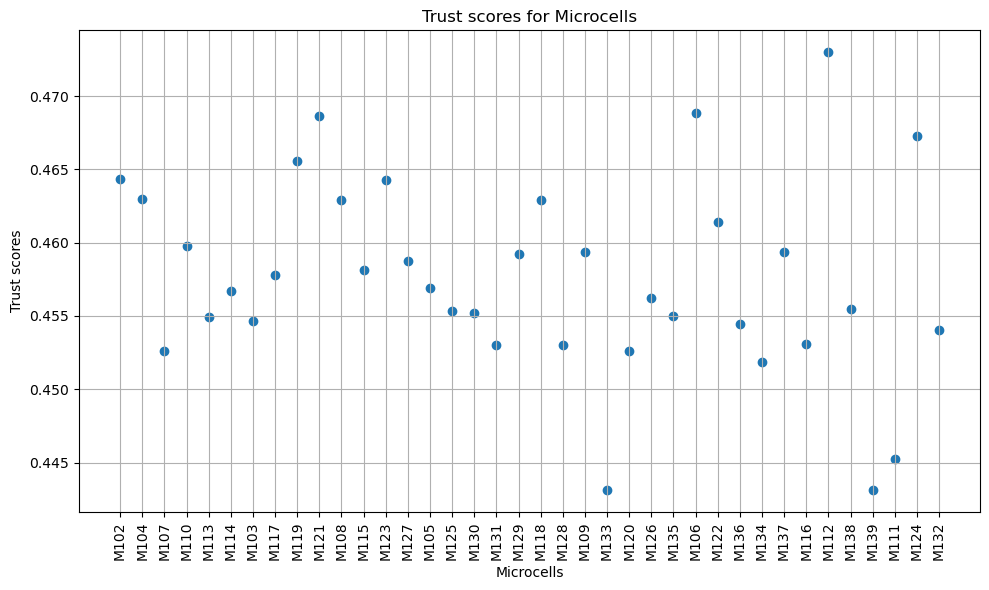

In [6]:

dfin = general.open_file_csv('data_alg_16000.csv')
dfin = general.slice_df(dfin,['serviceid','providerid','microcell','timestamp','speed','latency','bandwidth','coverage','reliability','security','currect_microcell'])





dfin=general.add_a_column_with_a_value(dfin,'origin','G')
dfin=general.add_a_column_with_a_value(dfin,'true_label','C')

dfin=general.add_a_column_with_a_value(dfin,'D_speed',0)
dfin=general.add_a_column_with_a_value(dfin,'D_latency',0)
dfin=general.add_a_column_with_a_value(dfin,'D_bandwidth',0)
dfin=general.add_a_column_with_a_value(dfin,'D_coverage',0)
dfin=general.add_a_column_with_a_value(dfin,'D_reliability',0)
dfin=general.add_a_column_with_a_value(dfin,'D_security',0)
dfin=general.add_a_column_with_a_value(dfin,'clusters',0)


data_list = general.dataframe_devide_to_microcell_dictionary(dfin)
data_rep=replication.replicate_totally(data_list,dfin)

merged_df = general.dictionary_to_merged_df(data_rep)
general.save_file(merged_df,'replicated_source.xlsx')
data_with_scores = general.trust_score_calculation(data_rep,[0.3,0.1,0.2,0.1,0.1,0.2])
general.visualize_data_one_value(data_with_scores)


In [7]:
# from components.detection import Detection



# detection = Detection()

In [8]:
import time

class Detection:
    def __init__(self):
        pass

    def detect_tampered_records(self,correct_data,tampered_data):
        time_val = []
        results_review ={}
        for key2, df2 in tampered_data.items():
            start_time = time.time()
            df2=general.add_a_column_with_a_value(df2,'label','NA')
            print("Microcell:"+key2)
            temp_provider_dfs={}
            unique_keys = df2.providerid.unique()
            for provider in unique_keys:
                temp_provider_dfs["{}".format(provider)] = df2[df2.providerid==provider]

            temp_provider_result_dfs={}
            for key_provider,df_provider in temp_provider_dfs.items():
                df2_received = df_provider[df_provider['origin'] == 'R']
                df2_generated = df_provider[df_provider['origin'] == 'G']
                df2_received=df2_received.reset_index(drop=True)
                if not df2_received.empty:
                    for i in range(len(df2_received)):
                        origin_record = correct_data[correct_data['serviceid']==df2_received.iloc[i]['serviceid']]  
                        if((df2_received.iloc[i]['speed']==origin_record.iloc[0]['speed']) and (df2_received.iloc[i]['latency']==origin_record.iloc[0]['latency'])and (df2_received.iloc[i]['bandwidth']==origin_record.iloc[0]['bandwidth'])and (df2_received.iloc[i]['coverage']==origin_record.iloc[0]['coverage'])and (df2_received.iloc[i]['reliability']==origin_record.iloc[0]['reliability'])and (df2_received.iloc[i]['security']==origin_record.iloc[0]['security'])):
                            df2_received.loc[i, 'label'] = 'C'
                        else:
                            df2_received.loc[i, 'label'] = 'T'
                df2_generated=df2_generated.reset_index(drop=True)
                if not df2_generated.empty:
                    for j in range(len(df2_generated)):
                        provider_other_df1 = correct_data[correct_data['providerid']==df2_generated.iloc[j]['providerid']]
                        provider_other_df = provider_other_df1[provider_other_df1['microcell']!=key2]
                        provider_other_df=provider_other_df.reset_index(drop=True)

                        if(provider_other_df.shape[0]>1):
                            df_to_clust = provider_other_df[[ 'speed','latency','bandwidth','coverage','reliability','security']]
                            dbscan = DBSCAN(eps=0.5, min_samples=5)
                            clusters = dbscan.fit_predict(df_to_clust)
                            outliers = provider_other_df.iloc[clusters == -1]
                            check_list = outliers['serviceid'].unique()
                            if df2_generated.iloc[j]['serviceid'] in check_list:
                                df2_generated.loc[j, 'label'] = 'S'
                            else:
                                df2_generated.loc[j, 'label'] = 'NS'
                        else:
                            df2_generated.loc[j, 'label'] = 'NS'

                t_count = (df2_received['label'] == 'T').sum()
                c_count = (df2_received['label'] == 'C').sum()
                if c_count + t_count != 0:
                    if((t_count/(c_count+t_count))<0.8):
                        df2_generated['label'].replace('S', 'C', inplace=True)
                        df2_generated['label'].replace('NS', 'C', inplace=True)
                    elif((t_count/(c_count+t_count))>0.8):
                        df2_generated['label'].replace('S', 'T', inplace=True)
                        df2_generated['label'].replace('NS', 'T', inplace=True)
                    
                    else:
                        df2_generated['label'].replace('S', 'T', inplace=True)
                        df2_generated['label'].replace('NS', 'C', inplace=True)
                else:
            
                    df2_generated['label'].replace('S', 'T', inplace=True)
                    df2_generated['label'].replace('NS', 'C', inplace=True)


                concatenated_df_provider = pd.concat([df2_generated, df2_received])
                temp_provider_result_dfs[key_provider] = concatenated_df_provider
            
            combined_microcell_df = general.dictionary_to_merged_df(temp_provider_result_dfs)
            results_review[key2] = combined_microcell_df
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_val.append([df2.shape[0],elapsed_time])
        return results_review,time_val




    def accuracy(self,y_true, y_pred):
        correct_predictions = 0
        total_predictions = len(y_true)
        for true, pred in zip(y_true, y_pred):
            if true == pred:
                correct_predictions += 1
        return correct_predictions / total_predictions

    def precision(self,y_true, y_pred, positive_class):
        true_positives = sum((true == positive_class) and (pred == positive_class) for true, pred in zip(y_true, y_pred))
        predicted_positives = sum(pred == positive_class for pred in y_pred)
        return true_positives / predicted_positives if predicted_positives != 0 else 0

    def recall(self,y_true, y_pred, positive_class):
        true_positives = sum((true == positive_class) and (pred == positive_class) for true, pred in zip(y_true, y_pred))
        actual_positives = sum(true == positive_class for true in y_true)
        return true_positives / actual_positives if actual_positives != 0 else 0
    

detection = Detection()


In [9]:

tamper1 = tampering.tamper_data1(data_with_scores,100,'N1',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores1 = general.trust_score_calculation(tamper1,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review1 = detection.detect_tampered_records(dfin,tampred_data_with_scores1)
results_review1 = sophistication.detect_sophistication(dfin,results_review1,[0.3,0.1,0.2,0.1,0.1,0.2])

viz1= results_review1['S_171']

tamper2 = tampering.tamper_data1(data_with_scores,100,'K3',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores2 = general.trust_score_calculation(tamper2,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review2 = detection.detect_tampered_records(dfin,tampred_data_with_scores2)
results_review2 = sophistication.detect_sophistication(dfin,results_review2,[0.3,0.1,0.2,0.1,0.1,0.2])

viz2= results_review2['S_171']

tamper3 = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores3 = general.trust_score_calculation(tamper3,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review3 = detection.detect_tampered_records(dfin,tampred_data_with_scores3)
results_review3 = sophistication.detect_sophistication(dfin,results_review3,[0.3,0.1,0.2,0.1,0.1,0.2])

viz3 = results_review3['S_171']

Microcell:M133
Microcell:M130
Microcell:M112
Microcell:M127
Microcell:M139
Microcell:M138
Microcell:M115
Microcell:M110
Microcell:M129
Microcell:M126
Microcell:M109
Microcell:M107
Microcell:M125
Microcell:M131
Microcell:M136
Microcell:M134
Microcell:M120
Microcell:M117
Microcell:M128
Microcell:M137
Microcell:M132
Microcell:M111
Microcell:M116
Microcell:M104
Microcell:M108
Microcell:M123
Microcell:M114
Microcell:M135
Microcell:M119
Microcell:M124
Microcell:M106
Microcell:M113
Microcell:M105
Microcell:M118
Microcell:M102
Microcell:M121
Microcell:M122
Microcell:M103
({'M133':       serviceid providerid microcell   timestamp  speed  latency  bandwidth  \
0        100184   P1000107      M133  2024-02-29    4.8      4.8        4.8   
1        105137   P1000107      M133  2024-03-04    4.8      4.8        4.8   
2        121583   P1000107      M133  2023-11-30    4.8      4.8        4.8   
3        122071   P1000107      M133  2023-11-24    4.8      4.8        4.8   
4        108986   P100010

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
list_k = []

def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    unique_labels = np.unique(labels)
    
    non_outlier_indices = np.where(labels != -1)[0]
    
    cluster_center = np.mean(data.iloc[non_outlier_indices], axis=0)


    list_k.append(cluster_center)

    # unique_labels = np.unique(labels[labels != -1])

    for label in unique_labels:
        if label == -1:
            outlier_data = data[labels == label]
            ax.scatter(outlier_data['Significance'], outlier_data['Trend'], outlier_data['Impact'], c='red', cmap='viridis', s=50, alpha=0.6, label='Outliers')
        else:
            cluster_data = data[labels == label]
            ax.scatter(cluster_data['Significance'], cluster_data['Trend'], cluster_data['Impact'], c='blue', cmap='viridis', s=50, alpha=0.6)


    ax.set_xlabel('Significance', rotation=20, fontsize=12, fontweight='bold')
    ax.set_ylabel('Trend', rotation=-30, fontsize=12, fontweight='bold')
    ax.set_zlabel('Impact', rotation=45, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

def plot_center(ax, points, title):
    print(points)
    ax.scatter(points[0]['Significance'], points[0]['Trend'], c='m', marker='o', label='Scenario 1. Naive', s=100)
    ax.scatter(points[1]['Significance'], points[1]['Trend'], c='orange', marker='^', label='Scenario 2. Knowledgeable', s=150)
    ax.scatter(points[2]['Significance'], points[2]['Trend'], c='green', marker='s', label='Scenario 3. Sophisticated', s=100)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Significance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trend', fontsize=12, fontweight='bold')
    ax.set_zlabel('Impact', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()


# combined_data = pd.concat([viz1, viz2, viz3], axis=0)

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Scale the combined data
# scaled_data = scaler.fit_transform(combined_data)

# # Create new dataframes for scaled data
# scaled_viz1 = pd.DataFrame(scaled_data[:len(viz1)], columns=viz1.columns)
# scaled_viz2 = pd.DataFrame(scaled_data[len(viz1):len(viz1) + len(viz2)], columns=viz2.columns)
# scaled_viz3 = pd.DataFrame(scaled_data[len(viz1) + len(viz2):], columns=viz3.columns)
scaler = MinMaxScaler()

# Scale the 'Significance', 'Trend', and 'Impact' values for all scenarios separately
viz1_scaled = scaler.fit_transform(viz1[['Significance', 'Trend', 'Impact']])
viz2_scaled = scaler.fit_transform(viz2[['Significance', 'Trend', 'Impact']])
viz3_scaled = scaler.fit_transform(viz3[['Significance', 'Trend', 'Impact']])

# Replace the original columns with scaled ones
viz1[['Significance', 'Trend', 'Impact']] = viz1_scaled
viz2[['Significance', 'Trend', 'Impact']] = viz2_scaled
viz3[['Significance', 'Trend', 'Impact']] = viz3_scaled
# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(25, 6), subplot_kw={'projection': '3d'})

# Plot for scaled viz1
plot_cluster_and_center(axs[0], viz1, '(A) Scenario 1. Naive tampering instance')

# Plot for scaled viz2
plot_cluster_and_center(axs[1], viz2, '(B) Scenario 2. Knowledgeable tampering instance')

# Plot for scaled viz3
plot_cluster_and_center(axs[2], viz3, '(C) Scenario 3. Sophisticated tampering instance')

plot_center(axs[3], list_k, '(D) Majority cluster center') 

plt.tight_layout()
plt.show()


### Replication

In [3]:
class Replication:
    def __init__(self):
        pass

    def replicate_totally(self,data_list,dfin):
        data={}
        column_names = ['serviceid','providerid','microcell','timestamp','speed','latency','bandwidth','coverage','reliability','security','currect_microcell']

        for key, value in data_list.items():
            df1 = value
            df1=df1.reset_index(drop=True)

            df_temporaty = pd.DataFrame(columns=column_names)
            list_test =[]
            for i in range (0,df1.shape[0]):
                dflag = dfin[dfin.providerid==df1['providerid'][i]]
                dflag = dflag.reset_index(drop=True)
                for j in range (0,dflag.shape[0]):
                    if(str(dflag['microcell'][j])!=key):
                        if(datetime.strptime(dflag['timestamp'][j], '%Y-%m-%d')<datetime.strptime(df1['timestamp'][i], '%Y-%m-%d')):
                            list_test.append(dflag.iloc[j])
            
            df_temporaty = pd.DataFrame(list_test)
            df_temporaty['origin'] = 'R'
            df_temporaty['currect_microcell'] = key
            df_temporaty=df_temporaty.reset_index(drop=True)
            df_no_duplicates = df_temporaty.drop_duplicates(subset='serviceid')
            result = pd.concat([df1, df_no_duplicates], axis=0)
            result = result.reset_index(drop=True)
            data[key] = result
        return data

### Tampering

In [4]:
class Tampering:
    def __init__(self):
        pass
    def tamper_data1(self, data, sp_percent, type, each_attribute=10, val=5,sig=[0.3,0.1,0.2,0.1,0.1,0.2]):
        sp_amount = len(data) * (sp_percent / 100)
        sampled_keys = random.sample(list(data.keys()), round(sp_amount))
        tampered_data = {}


        for key in sampled_keys:
            df = data[key]
            dftamper = df.copy()
            dftamper=dftamper.reset_index(drop=True)
            if type == "N1":
                if not dftamper.empty:
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = 4.8
                    dftamper['true_label'] = 'T'
            elif type == "N2":
                if not dftamper.empty:
                    num_rows_to_tamper = int(0.5 * len(dftamper))
                    rows_to_tamper = np.random.choice(dftamper.index, num_rows_to_tamper, replace=False)
                    dftamper.loc[rows_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = 4.8
                    dftamper.loc[rows_to_tamper, 'true_label'] = 'T'

            elif type == "K1":
                if not dftamper.empty:
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] *= (1 + (each_attribute / 100))
                    dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = np.minimum(dftamper[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']], val)
                    dftamper['true_label'] = 'T'

            elif type == "K2":
                if not dftamper.empty:
                    unique_providers = dftamper['providerid'].unique()
                    num_providers_to_tamper = int(0.5 * len(unique_providers))
                    providers_to_tamper = random.sample(list(unique_providers), num_providers_to_tamper)
                    records_to_tamper = dftamper[dftamper['providerid'].isin(providers_to_tamper)].index
                    dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] *= (1 + (each_attribute / 100))
                    dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']] = np.minimum(dftamper.loc[records_to_tamper, ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']], val)
                    dftamper.loc[records_to_tamper, 'true_label'] = 'T'
            
            elif type == "K3":
                highest_3 = sorted(sig, reverse=True)[:3]
                
                result = [1 if value in highest_3 else 0 for value in sig]
                print(result)
                if not dftamper.empty:
                    for line in range(0, dftamper.shape[0]):
                        dftamper.loc[line, 'speed'] = min(round(dftamper.loc[line, 'speed'] * (1 + result[0]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'latency'] = min(round(dftamper.loc[line, 'latency'] * (1 + result[1]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'bandwidth'] = min(round(dftamper.loc[line, 'bandwidth'] * (1 + result[2]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'coverage'] = min(round(dftamper.loc[line, 'coverage'] * (1 + result[3]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'reliability'] = min(round(dftamper.loc[line, 'reliability'] * (1 + result[4]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'security'] = min(round(dftamper.loc[line, 'security'] * (1 + result[5]*(each_attribute / 100))), val)
                        dftamper.loc[line, 'true_label'] = 'T'
            elif type == "S1":
                if not dftamper.empty:
                    grouped = dftamper.groupby('providerid')
                    for providerid, group_df in grouped:
                        if len(group_df) >= 2:
                            lowest_index = group_df['TS'].idxmin()
                            highest_index = group_df['TS'].idxmax()
                            dftamper.loc[lowest_index, 'speed'] = dftamper.loc[highest_index, 'speed'] 
                            dftamper.loc[lowest_index, 'latency'] = dftamper.loc[highest_index, 'latency'] 
                            dftamper.loc[lowest_index, 'bandwidth'] = dftamper.loc[highest_index, 'bandwidth'] 
                            dftamper.loc[lowest_index, 'coverage'] = dftamper.loc[highest_index, 'coverage'] 
                            dftamper.loc[lowest_index, 'reliability'] = dftamper.loc[highest_index, 'reliability'] 
                            dftamper.loc[lowest_index, 'security'] = dftamper.loc[highest_index, 'security']  
                            dftamper.loc[lowest_index, 'true_label'] = 'T'
            elif type == "S2":

                if not dftamper.empty:
                    grouped = dftamper.groupby('providerid')
                    for providerid, group_df in grouped:
                        if len(group_df) >= 2:
                            lowest_index = group_df['TS'].idxmin()

                            dftamper.loc[lowest_index, 'speed'] = group_df['speed'].mean()
                            dftamper.loc[lowest_index, 'latency'] = group_df['latency'].mean() 
                            dftamper.loc[lowest_index, 'bandwidth'] = group_df['bandwidth'].mean() 
                            dftamper.loc[lowest_index, 'coverage'] = group_df['coverage'].mean() 
                            dftamper.loc[lowest_index, 'reliability'] = group_df['reliability'].mean() 
                            dftamper.loc[lowest_index, 'security'] =  group_df['security'].mean() 
                            dftamper.loc[lowest_index, 'true_label'] = 'T'
            tampered_data[key] = dftamper


        untampered_data = {key: value for key, value in data.items() if key not in tampered_data}

        # print("*************")
        # for key in untampered_data:
        #     print(key)
        #     df = data[key]
        #     print(df.shape[0])
        # print("tampered",len(tampered_data))
        # print("untampered",len(untampered_data))
        return {**untampered_data, **tampered_data}
    

        




tampering = Tampering()

### Detection

In [5]:
general = GeneralOp()
replication =  Replication()
tampering = Tampering()



### Baseline

In [6]:

import pandas as pd
import time

class Baseline:
    def __init__(self):
        pass
        
    def baseline_detection_1(self, tampered_data):
        time_val=[]
        microcell_data = {}
        for key2, df2 in tampered_data.items():
            start_time = time.time()
            print("Baseline Microcell:"+key2)
            temp_provider_dfs = {}
            unique_keys = df2.providerid.unique()
            for provider in unique_keys:
                temp_provider_dfs["{}".format(provider)] = df2[df2.providerid == provider]

            temp_provider_result_dfs = {}
            for key_provider, df_provider in temp_provider_dfs.items():
                df_provider = df_provider.reset_index(drop=True)
                df_provider = df_provider.copy() 
                features = ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']
                X = df_provider[features]
                
                # Custom check for identical records
                if len(X.drop_duplicates()) == 1:
                    # print("All records are identical in provider:", key_provider)
                    # You can choose to flag this as tampered or take other actions
                    df_provider['is_outlier'] = -1  # Assuming -1 represents tampered data
                else:
                    isolation_forest = IsolationForest(contamination=0.1, random_state=42)
                    isolation_forest.fit(X)
                    outliers = isolation_forest.predict(X)
                    df_provider['is_outlier'] = outliers
                
                df_provider['label'] = df_provider['is_outlier'].apply(lambda x: 'T' if x == -1 else 'C')
                temp_provider_result_dfs[key_provider] = df_provider
                
            combined_microcell_df = general.dictionary_to_merged_df(temp_provider_result_dfs)
            microcell_data[key2] = combined_microcell_df
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_val.append([df2.shape[0],elapsed_time])
        return general.dictionary_to_merged_df(microcell_data),time_val

baseline = Baseline()



### Code Execution

In [ ]:


dfin = general.open_file('data_source_v2_morethan_2.xlsx')
dfin = general.slice_df(dfin,['serviceid','providerid','microcell','timestamp','speed','latency','bandwidth','coverage','reliability','security','currect_microcell'])





dfin=general.add_a_column_with_a_value(dfin,'origin','G')
dfin=general.add_a_column_with_a_value(dfin,'true_label','C')

dfin=general.add_a_column_with_a_value(dfin,'D_speed',0)
dfin=general.add_a_column_with_a_value(dfin,'D_latency',0)
dfin=general.add_a_column_with_a_value(dfin,'D_bandwidth',0)
dfin=general.add_a_column_with_a_value(dfin,'D_coverage',0)
dfin=general.add_a_column_with_a_value(dfin,'D_reliability',0)
dfin=general.add_a_column_with_a_value(dfin,'D_security',0)
dfin=general.add_a_column_with_a_value(dfin,'clusters',0)


data_list = general.dataframe_devide_to_microcell_dictionary(dfin)
data_rep=replication.replicate_totally(data_list,dfin)

merged_df = general.dictionary_to_merged_df(data_rep)
general.save_file(merged_df,'replicated_source.xlsx')
data_with_scores = general.trust_score_calculation(data_rep,[0.3,0.1,0.2,0.1,0.1,0.2])
general.visualize_data_one_value(data_with_scores)



### Check tampering - Results

In [8]:
import time

class Detection:
    def __init__(self):
        pass

    def detect_tampered_records(self,correct_data,tampered_data):
        time_val = []
        results_review ={}
        for key2, df2 in tampered_data.items():
            start_time = time.time()
            df2=general.add_a_column_with_a_value(df2,'label','NA')
            print("Microcell:"+key2)
            temp_provider_dfs={}
            unique_keys = df2.providerid.unique()
            for provider in unique_keys:
                temp_provider_dfs["{}".format(provider)] = df2[df2.providerid==provider]

            temp_provider_result_dfs={}
            for key_provider,df_provider in temp_provider_dfs.items():
                df2_received = df_provider[df_provider['origin'] == 'R']
                df2_generated = df_provider[df_provider['origin'] == 'G']
                df2_received=df2_received.reset_index(drop=True)
                if not df2_received.empty:
                    for i in range(len(df2_received)):
                        origin_record = correct_data[correct_data['serviceid']==df2_received.iloc[i]['serviceid']]  
                        if((df2_received.iloc[i]['speed']==origin_record.iloc[0]['speed']) and (df2_received.iloc[i]['latency']==origin_record.iloc[0]['latency'])and (df2_received.iloc[i]['bandwidth']==origin_record.iloc[0]['bandwidth'])and (df2_received.iloc[i]['coverage']==origin_record.iloc[0]['coverage'])and (df2_received.iloc[i]['reliability']==origin_record.iloc[0]['reliability'])and (df2_received.iloc[i]['security']==origin_record.iloc[0]['security'])):
                            df2_received.loc[i, 'label'] = 'C'
                        else:
                            df2_received.loc[i, 'label'] = 'T'
                df2_generated=df2_generated.reset_index(drop=True)
                if not df2_generated.empty:
                    for j in range(len(df2_generated)):
                        provider_other_df1 = correct_data[correct_data['providerid']==df2_generated.iloc[j]['providerid']]
                        provider_other_df = provider_other_df1[provider_other_df1['microcell']!=key2]
                        provider_other_df=provider_other_df.reset_index(drop=True)

                        if(provider_other_df.shape[0]>1):
                            df_to_clust = provider_other_df[[ 'speed','latency','bandwidth','coverage','reliability','security']]
                            dbscan = DBSCAN(eps=0.5, min_samples=5)
                            clusters = dbscan.fit_predict(df_to_clust)
                            outliers = provider_other_df.iloc[clusters == -1]
                            check_list = outliers['serviceid'].unique()
                            if df2_generated.iloc[j]['serviceid'] in check_list:
                                df2_generated.loc[j, 'label'] = 'S'
                            else:
                                df2_generated.loc[j, 'label'] = 'NS'
                        else:
                            df2_generated.loc[j, 'label'] = 'NS'

                t_count = (df2_received['label'] == 'T').sum()
                c_count = (df2_received['label'] == 'C').sum()
                if c_count + t_count != 0:
                    if((t_count/(c_count+t_count))<0.8):
                        df2_generated['label'].replace('S', 'C', inplace=True)
                        df2_generated['label'].replace('NS', 'C', inplace=True)
                    elif((t_count/(c_count+t_count))>0.8):
                        df2_generated['label'].replace('S', 'T', inplace=True)
                        df2_generated['label'].replace('NS', 'T', inplace=True)
                    
                    else:
                        df2_generated['label'].replace('S', 'T', inplace=True)
                        df2_generated['label'].replace('NS', 'C', inplace=True)
                else:
            
                    df2_generated['label'].replace('S', 'T', inplace=True)
                    df2_generated['label'].replace('NS', 'C', inplace=True)


                concatenated_df_provider = pd.concat([df2_generated, df2_received])
                temp_provider_result_dfs[key_provider] = concatenated_df_provider
            
            combined_microcell_df = general.dictionary_to_merged_df(temp_provider_result_dfs)
            results_review[key2] = combined_microcell_df
            end_time = time.time()
            elapsed_time = end_time - start_time
            time_val.append([df2.shape[0],elapsed_time])
        return results_review,time_val




    def accuracy(self,y_true, y_pred):
        correct_predictions = 0
        total_predictions = len(y_true)
        for true, pred in zip(y_true, y_pred):
            if true == pred:
                correct_predictions += 1
        return correct_predictions / total_predictions

    def precision(self,y_true, y_pred, positive_class):
        true_positives = sum((true == positive_class) and (pred == positive_class) for true, pred in zip(y_true, y_pred))
        predicted_positives = sum(pred == positive_class for pred in y_pred)
        return true_positives / predicted_positives if predicted_positives != 0 else 0

    def recall(self,y_true, y_pred, positive_class):
        true_positives = sum((true == positive_class) and (pred == positive_class) for true, pred in zip(y_true, y_pred))
        actual_positives = sum(true == positive_class for true in y_true)
        return true_positives / actual_positives if actual_positives != 0 else 0
    

detection = Detection()


### Experiments

In [9]:
# dfs_time1 = []
# dfs_time2 = []

# for i in range(10):
#     print(i)
#     test = tampering.tamper_data1(data_with_scores,100,'N2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])
#     tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
#     results_review,time1 = detection.detect_tampered_records(dfin,tampred_data_with_scores)
#     check_baseline,time2 = baseline.baseline_detection_1(tampred_data_with_scores)
#     df1 = pd.DataFrame(time1, columns=['Value', 'Time'])
#     df2 = pd.DataFrame(time2, columns=['Value', 'Time'])
#     dfs_time1.append(df1)
#     dfs_time2.append(df2)
# df_time1_concat = pd.concat(dfs_time1)
# df_time2_concat = pd.concat(dfs_time2)

# # Calculate average time per value
# average_time_per_value_1 = df_time1_concat.groupby('Value')['Time'].mean()
# average_time_per_value_2 = df_time2_concat.groupby('Value')['Time'].mean()

# print("Average time per value for time1:")
# print(average_time_per_value_1)
# print("\nAverage time per value for time2:")
# print(average_time_per_value_2)

In [10]:
# x_values_1 = average_time_per_value_1.index
# y_values_1 = average_time_per_value_1.values

# # Extract x and y values for average_time_per_value_2
# x_values_2 = average_time_per_value_2.index
# y_values_2 = average_time_per_value_2.values

# # Plotting the scatter plot for average_time_per_value_1
# plt.figure(figsize=(10, 6))
# plt.scatter(x_values_1, y_values_1, color='blue', marker='o', label='Our Approch')

# # Plotting the scatter plot for average_time_per_value_2
# plt.scatter(x_values_2, y_values_2, color='red', marker='x', label='Baseline')

# plt.title('Time Vs Number of trust information records')
# plt.xlabel('Number of trust information entries')
# plt.ylabel('Time taken (seconds)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [11]:
# dfs_time1 = []
# dfs_time2 = []



# test = tampering.tamper_data1(data_with_scores,100,'K3',sig=[0.3,0.1,0.2,0.1,0.1,0.2])
# tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
# data_use = test['S_171']

# for k in range(3):
#     time1_list =[]
#     time2_list =[]
#     for i in range(250, len(data_use)+1, 250):
#         input_data ={}
#         selected_records = data_use[:i]

#         input_data['S_171'] = selected_records
#         results_review,time1 = detection.detect_tampered_records(dfin,input_data)
#         check_baseline,time2 = baseline.baseline_detection_1(input_data)

#         time1_list.append(time1[0])
#         time2_list.append(time2[0])

#     df1 = pd.DataFrame(time1_list, columns=['Number of Records', 'Values'])
#     df2 = pd.DataFrame(time2_list, columns=['Number of Records', 'Values'])
#     dfs_time1.append(df1)
#     dfs_time2.append(df2)
 

# df_time1_concat = pd.concat(dfs_time1)
# df_time2_concat = pd.concat(dfs_time2)

# # # Calculate average time per value
# average_time_per_value_1 = df_time1_concat.groupby('Number of Records')['Values'].mean()
# average_time_per_value_2 = df_time2_concat.groupby('Number of Records')['Values'].mean()
    

# plt.figure(figsize=(10, 5))

# plt.plot(average_time_per_value_1.index, average_time_per_value_1.values, color='blue', marker='o', label='Our Approach (TDA)')
# plt.plot(average_time_per_value_2.index, average_time_per_value_2.values, color='red', marker='x', label='Isolation forest approach(IFUM)')

# plt.xlabel('Number of trust information entries')
# plt.ylabel('Time taken (seconds)')
# # plt.title('Time Vs Number of trust information records')
# plt.legend()

# plt.grid(True)
# plt.show()



In [12]:
# average_time_per_value_1.to_excel('sample3.xlsx')
# average_time_per_value_1.to_excel('sample4.xlsx')

In [13]:
# plt.figure(figsize=(10, 5))

# plt.plot(average_time_per_value_1.index, average_time_per_value_1.values, color='blue', marker='o', label='Our Approach (TDA)')
# plt.plot(average_time_per_value_2.index, average_time_per_value_2.values, color='red', marker='x', label='Isolation forest approach(IFUM)')

# plt.xlabel('Number of trust information entries', fontsize=12,fontweight='bold')
# plt.ylabel('Time taken (seconds)',fontsize=12,fontweight='bold')
# # plt.title('Time Vs Number of trust information records')
# plt.legend()

# plt.grid(True)
# plt.show()

In [14]:
# average_time_per_value_1 = df_time1_concat.groupby('Number of Records')['Values'].mean()
# average_time_per_value_2 = df_time2_concat.groupby('Number of Records')['Values'].mean()
    

# plt.figure(figsize=(10, 5))

# plt.plot(average_time_per_value_1.index, average_time_per_value_1.values, color='blue', marker='o', label='Our Approach (TDA)')
# plt.plot(average_time_per_value_2.index, average_time_per_value_2.values, color='red', marker='x', label='Isolation Forest Approach')

# plt.xlabel('Number of trust information entries')
# plt.ylabel('Time taken (seconds)')
# plt.title('Time Vs Number of trust information records')
# plt.legend()

# plt.grid(True)
# plt.show()

In [15]:
# average_time_per_value_1

In [16]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))

# plt.plot(average_time_per_value_1.index, average_time_per_value_1.values, color='blue', marker='o', label='Our Approach (TDA)')
# plt.plot(average_time_per_value_2.index, average_time_per_value_2.values, color='red', marker='x', label='Isolation Forest Approach')

# plt.xlabel('Number of trust information entries')
# plt.ylabel('Time taken (seconds)')
# plt.title('Time Vs Number of trust information records')
# plt.legend()

# plt.grid(True)
# plt.show()

# # # Data

# # data1 = average_time_per_value_1
# # # [[1000, 1.90995192527771], [2000, 3.8787338733673096], [3000, 5.616695165634155], [4000, 6.284044027328491]]
# # data2 = average_time_per_value_1
# # # [[1000, 8.451188802719116], [2000, 23.158337116241455], [3000, 22.726451873779297], [4000, 25.096271991729736]]

# # # Extract x and y values for plotting
# # x1, y1 = zip(*data1)
# # x2, y2 = zip(*data2)

# # # Plotting
# # plt.figure(figsize=(10, 5))

# # plt.plot(x1, y1,color='blue', marker='o', label='Our Approch (TDA)')
# # plt.plot(x2, y2, color='red', marker='x', label='Isolation forest approch')

# # plt.xlabel('Number of trust information entries')
# # plt.ylabel('Time taken (seconds)')
# # plt.title('Time Vs Number of trust information records')
# # plt.legend()

# # plt.grid(True)
# # plt.show()



In [17]:
# dfs_time1 = []
# dfs_time2 = []

# for i in range(10):
#     print(i)
#     test = tampering.tamper_data1(data_with_scores,100,'K3',sig=[0.3,0.1,0.2,0.1,0.1,0.2])
#     tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
#     results_review,time1 = detection.detect_tampered_records(dfin,tampred_data_with_scores)
#     check_baseline,time2 = baseline.baseline_detection_1(tampred_data_with_scores)
#     df1 = pd.DataFrame(time1, columns=['Value', 'Time'])
#     df2 = pd.DataFrame(time2, columns=['Value', 'Time'])
#     dfs_time1.append(df1)
#     dfs_time2.append(df2)
# df_time1_concat = pd.concat(dfs_time1)
# df_time2_concat = pd.concat(dfs_time2)

# # Calculate average time per value
# average_time_per_value_1 = df_time1_concat.groupby('Value')['Time'].mean()
# average_time_per_value_2 = df_time2_concat.groupby('Value')['Time'].mean()

# print("Average time per value for time1:")
# print(average_time_per_value_1)
# print("\nAverage time per value for time2:")
# print(average_time_per_value_2)

# x_values_1 = average_time_per_value_1.index
# y_values_1 = average_time_per_value_1.values

# # Extract x and y values for average_time_per_value_2
# x_values_2 = average_time_per_value_2.index
# y_values_2 = average_time_per_value_2.values

# # Plotting the scatter plot for average_time_per_value_1
# plt.figure(figsize=(10, 6))
# plt.scatter(x_values_1, y_values_1, color='blue', marker='o', label='Our Approch')

# # Plotting the scatter plot for average_time_per_value_2
# plt.scatter(x_values_2, y_values_2, color='red', marker='x', label='Baseline')

# plt.title('Time Vs Number of trust information records')
# plt.xlabel('Number of trust information entries')
# plt.ylabel('Time taken (seconds)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [18]:
# x_values = average_time_per_value_1['Value']
# y_values = [pair[1] for pair in average_time_per_value_1]

# # Plotting the scatter plot

# plt.figure(figsize=(10, 6))
# plt.scatter(x_values, y_values, color='blue', marker='o')
# plt.title('Time Vs Number of trust information records')
# plt.xlabel('Number of trust infromation entries')
# plt.ylabel('Time taken (seconds)')
# plt.grid(True)
# plt.show()

In [19]:
# x_values = [pair[0] for pair in time2]
# y_values = [pair[1] for pair in time2]

# # Plotting the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x_values, y_values, color='blue', marker='o')
# plt.title('Time Vs Number of trust information records')
# plt.xlabel('Number of trust infromation entries')
# plt.ylabel('Time taken (seconds)')
# plt.grid(True)
# plt.show()

In [20]:
# x_values = [pair[0] for pair in time1]
# y_values = [pair[1] for pair in time1]
# z_values = [pair[1] for pair in time2]

# # Plotting the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x_values, y_values, color='blue', marker='o')
# plt.scatter(x_values, z_values, color='red', marker='x')
# plt.title('Time Vs Number of trust information records')
# plt.xlabel('Number of trust infromation entries')
# plt.ylabel('Time taken (seconds)')
# plt.grid(True)
# plt.show()

In [21]:
# results_review

In [8]:
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler


class Sophistication:
    def __init__(self):
        pass

    def detect_sophistication(self, correct_data, tampered_data, weight):
        results_review = {}

        df_sct = general.dictionary_to_merged_df(tampered_data)
        df_sct = df_sct[df_sct['label'] == 'T']
        tampered_data = general.dataframe_devide_to_microcell_dictionary(df_sct)

        for key2, df2 in tampered_data.items():
            df2_received = df2[(df2['label'] == 'T') & (df2['origin'] == 'R')]
            df2_generated = df2[(df2['label'] == 'T') & (df2['origin'] == 'G')]

            if not df2_received.empty:
                df2_received = self._process_received_data(df2_received, correct_data)

            if not df2_generated.empty:
                df2_generated = self._process_generated_data(df2_generated, correct_data, key2)

            combined_microcell_df = pd.concat([df2_generated, df2_received])
            combined_microcell_df = combined_microcell_df[combined_microcell_df['D_speed'] != 'NC']
            combined_microcell_df = combined_microcell_df[(combined_microcell_df['speed'] != 0) &
                                        (combined_microcell_df['latency'] != 0) &
                                        (combined_microcell_df['bandwidth'] != 0) &
                                        (combined_microcell_df['coverage'] != 0) &
                                        (combined_microcell_df['reliability'] != 0) &
                                        (combined_microcell_df['security'] != 0)]
            combined_microcell_df=combined_microcell_df.reset_index(drop=True)
            nc_count = combined_microcell_df['D_speed'].value_counts().get('NC', 0)
            total_count = len(combined_microcell_df['D_speed'])

            print("Microcell:", key2)
            print("Count of 'NC':", nc_count)
            print("Total count:", total_count)

            results_review[key2] = combined_microcell_df
        print("*********second part************")
        out_data={}
        for key, df in results_review.items():
            df=df.reset_index(drop=True)
            
            sample_list =[]

            impact = self._calculate_impact(df, weight)
            sig = self._calculate_significance(df, weight)
            trend = self._calculate_trend(df,correct_data)
            data = {'Impact': impact, 'Significance': sig, 'Trend': trend}

            new_df = pd.DataFrame(data)
            new_df = new_df[new_df['Trend'] != 'NC']
            new_df=new_df.reset_index(drop=True)
            print(key,new_df.shape[0])
            out_data[key] = new_df
            # print(new_df)
            # results_review[key2]= new_df

        return out_data

    def _process_received_data(self, df_received, correct_data):
        for i, row in df_received.iterrows():
            origin_record = correct_data[correct_data['serviceid'] == row['serviceid']]
            for attr in ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']:
                df_received.at[i, f'D_{attr}'] = origin_record[attr].values[0] if not origin_record.empty else 'NC'
        return df_received

    def _process_generated_data(self, df_generated, correct_data, key2):
        for i, row in df_generated.iterrows():
            provider_other_df = correct_data[(correct_data['providerid'] == row['providerid']) & (correct_data['microcell'] != key2)]
            if len(provider_other_df) > 1:
                mean_values = provider_other_df[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']].mean()
                df_generated.loc[i, 'D_speed':'D_security'] = mean_values.values
            else:
                df_generated.loc[i, 'D_speed':'D_security'] = 'NC'
        return df_generated
    def _calculate_impact(self, df_row, weight):
        d_speed = df_row['speed'] - df_row['D_speed']
        d_latency = df_row['latency'] - df_row['D_latency']
        d_bandwidth = df_row['bandwidth'] - df_row['D_bandwidth']
        d_coverage = df_row['coverage'] - df_row['D_coverage']
        d_reliability = df_row['reliability'] - df_row['D_reliability']
        d_security = df_row['security'] - df_row['D_security']

        impact = (d_speed * weight[0] + d_latency * weight[1] + d_bandwidth * weight[2] +
                d_coverage * weight[3] + d_reliability * weight[4] + d_security * weight[5]).div(5)
        impact = impact.clip(lower=0)
        return impact

    def _calculate_significance(self, df_row, weight1):
        power = 1  # You can adjust this power value to enhance the weights of higher values
        powered_matrix = [x ** power for x in weight1]
        total_sum = sum(powered_matrix)
        weight = [x / total_sum for x in powered_matrix]
        print(weight)
        sig_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                sig_list.append(0)
            else:
                percent_speed = (df_row.iloc[i]['speed'] - df_row.iloc[i]['D_speed'])
                percent_latency = (df_row.iloc[i]['latency'] - df_row.iloc[i]['D_latency'])
                percent_bandwidth = (df_row.iloc[i]['bandwidth'] - df_row.iloc[i]['D_bandwidth'])
                percent_coverage = (df_row.iloc[i]['coverage'] - df_row.iloc[i]['D_coverage'])
                percent_reliability = (df_row.iloc[i]['reliability'] - df_row.iloc[i]['D_reliability'])
                percent_security = (df_row.iloc[i]['security'] - df_row.iloc[i]['D_security'])
                num_changed = sum(abs(percent_change) > 0 for percent_change in
                  [percent_speed, percent_latency, percent_bandwidth, percent_coverage,
                   percent_reliability, percent_security])
                
                significance =  (1 if percent_speed > 0 else 0)  * weight[0] + \
                            (1 if percent_latency > 0 else 0)   * weight[1] + \
                            (1 if percent_bandwidth > 0 else 0)  * weight[2] + \
                            (1 if percent_coverage > 0 else 0)  * weight[3] + \
                            (1 if percent_reliability > 0 else 0)  * weight[4] + \
                            (1 if percent_security > 0 else 0) * weight[5]
                
                # significance =  percent_speed  * weight[0] + \
                #             percent_latency  * weight[1] + \
                #             percent_bandwidth * weight[2] + \
                #             percent_coverage * weight[3] + \
                #             percent_reliability * weight[4] + \
                #             percent_security* weight[5]

                
                significance = max(significance,0)
                sig_list.append((significance) / num_changed)
           
                
        return sig_list

    def _calculate_trend(self, df_row, dfcorrect):
        trend_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                trend_list.append(0)
            else:
                temp_df = dfcorrect[dfcorrect['providerid'] == df_row.iloc[i]['providerid']]
                temp_df = temp_df[temp_df['serviceid'] != df_row.iloc[i]['serviceid']]
                if temp_df.shape[0] > 0:
                    s_mean = temp_df['speed'].mean()
                    l_mean = temp_df['latency'].mean()
                    b_mean = temp_df['bandwidth'].mean()
                    c_mean = temp_df['coverage'].mean()
                    r_mean = temp_df['reliability'].mean()
                    sec_mean = temp_df['security'].mean()

                    s_trend = df_row.iloc[i]['speed'] - s_mean
                    l_trend = df_row.iloc[i]['latency'] - l_mean
                    b_trend = df_row.iloc[i]['bandwidth'] - b_mean
                    c_trend = df_row.iloc[i]['coverage'] - c_mean
                    r_trend = df_row.iloc[i]['reliability'] - r_mean
                    sec_trend = df_row.iloc[i]['security'] - sec_mean
                    normalized_s_trend = self._normalize_trend(s_trend)
                    normalized_l_trend = self._normalize_trend(l_trend)
                    normalized_b_trend = self._normalize_trend(b_trend)
                    normalized_c_trend = self._normalize_trend(c_trend)
                    normalized_r_trend = self._normalize_trend(r_trend)
                    normalized_sec_trend = self._normalize_trend(sec_trend)

                    total_trend = (normalized_s_trend + normalized_l_trend + normalized_b_trend +
                                normalized_c_trend + normalized_r_trend + normalized_sec_trend) / 6
                    total_trend = max(total_trend,0)
                else:
                    total_trend = 'NC'
                trend_list.append(total_trend)
           
                
        return trend_list

    def _normalize_trend(self, trend_value):
        min_value = 0
        max_value = 5
        score = 1 - (trend_value - min_value) / (max_value - min_value)
        return max(0, min(score, 1))
 

   


sophistication = Sophistication()


In [ ]:
tamper1 = tampering.tamper_data1(data_with_scores,100,'N1',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores1 = general.trust_score_calculation(tamper1,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review1,time1 = detection.detect_tampered_records(dfin,tampred_data_with_scores1)
results_review1 = sophistication.detect_sophistication(dfin,results_review1,[0.3,0.1,0.2,0.1,0.1,0.2])

viz1= results_review1['S_171']

tamper2 = tampering.tamper_data1(data_with_scores,100,'K3',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores2 = general.trust_score_calculation(tamper2,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review2,time2 = detection.detect_tampered_records(dfin,tampred_data_with_scores2)
results_review2 = sophistication.detect_sophistication(dfin,results_review2,[0.3,0.1,0.2,0.1,0.1,0.2])

viz2= results_review2['S_171']

tamper3 = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores3 = general.trust_score_calculation(tamper3,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review3,time3 = detection.detect_tampered_records(dfin,tampred_data_with_scores3)
results_review3 = sophistication.detect_sophistication(dfin,results_review3,[0.3,0.1,0.2,0.1,0.1,0.2])

viz3 = results_review3['S_171']

In [ ]:



from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming viz1, viz2, and viz3 are DataFrames containing data for visualization

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(viz1['Significance'], viz1['Trend'], viz1['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 1 (Naive)")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(viz2['Significance'], viz2['Trend'], viz2['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 2 (Knowledgeable)")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(viz3['Significance'], viz3['Trend'], viz3['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 3 (Sophisticated)")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()


In [ ]:
list_k = []

def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    unique_labels = np.unique(labels)
    
    non_outlier_indices = np.where(labels != -1)[0]
    
    cluster_center = np.mean(data.iloc[non_outlier_indices], axis=0)


    list_k.append(cluster_center)

    # unique_labels = np.unique(labels[labels != -1])

    for label in unique_labels:
        if label == -1:
            outlier_data = data[labels == label]
            ax.scatter(outlier_data['Significance'], outlier_data['Trend'], outlier_data['Impact'], c='red', cmap='viridis', s=50, alpha=0.6, label='Outliers')
        else:
            cluster_data = data[labels == label]
            ax.scatter(cluster_data['Significance'], cluster_data['Trend'], cluster_data['Impact'], c='blue', cmap='viridis', s=50, alpha=0.6)


    ax.set_xlabel('Significance', rotation=20, fontsize=12, fontweight='bold')
    ax.set_ylabel('Trend', rotation=-30, fontsize=12, fontweight='bold')
    ax.set_zlabel('Impact', rotation=45, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

def plot_center(ax, points, title):
    print(points)
    ax.scatter(points[0]['Significance'], points[0]['Trend'], c='m', marker='o', label='Scenario 1. Naive', s=100)
    ax.scatter(points[1]['Significance'], points[1]['Trend'], c='orange', marker='^', label='Scenario 2. Knowledgeable', s=150)
    ax.scatter(points[2]['Significance'], points[2]['Trend'], c='green', marker='s', label='Scenario 3. Sophisticated', s=100)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Significance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trend', fontsize=12, fontweight='bold')
    ax.set_zlabel('Impact', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()


# combined_data = pd.concat([viz1, viz2, viz3], axis=0)

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Scale the combined data
# scaled_data = scaler.fit_transform(combined_data)

# # Create new dataframes for scaled data
# scaled_viz1 = pd.DataFrame(scaled_data[:len(viz1)], columns=viz1.columns)
# scaled_viz2 = pd.DataFrame(scaled_data[len(viz1):len(viz1) + len(viz2)], columns=viz2.columns)
# scaled_viz3 = pd.DataFrame(scaled_data[len(viz1) + len(viz2):], columns=viz3.columns)
scaler = MinMaxScaler()

# Scale the 'Significance', 'Trend', and 'Impact' values for all scenarios separately
viz1_scaled = scaler.fit_transform(viz1[['Significance', 'Trend', 'Impact']])
viz2_scaled = scaler.fit_transform(viz2[['Significance', 'Trend', 'Impact']])
viz3_scaled = scaler.fit_transform(viz3[['Significance', 'Trend', 'Impact']])

# Replace the original columns with scaled ones
viz1[['Significance', 'Trend', 'Impact']] = viz1_scaled
viz2[['Significance', 'Trend', 'Impact']] = viz2_scaled
viz3[['Significance', 'Trend', 'Impact']] = viz3_scaled
# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(25, 6), subplot_kw={'projection': '3d'})

# Plot for scaled viz1
plot_cluster_and_center(axs[0], viz1, '(A) Scenario 1. Naive tampering instance')

# Plot for scaled viz2
plot_cluster_and_center(axs[1], viz2, '(B) Scenario 2. Knowledgeable tampering instance')

# Plot for scaled viz3
plot_cluster_and_center(axs[2], viz3, '(C) Scenario 3. Sophisticated tampering instance')

plot_center(axs[3], list_k, '(D) Majority cluster center') 

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Assuming viz1, viz2, and viz3 are DataFrames containing data for visualization

# Concatenate the data frames
combined_data = pd.concat([viz1[['Significance']], viz2[['Significance']], viz3[['Significance']]], axis=0)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the 'Significance' values for all scenarios together
scaled_significance = scaler.fit_transform(combined_data)

# Split the scaled data back into separate arrays for each scenario
viz1_scaled = scaled_significance[:len(viz1)]
viz2_scaled = scaled_significance[len(viz1):len(viz1) + len(viz2)]
viz3_scaled = scaled_significance[len(viz1) + len(viz2):]

# Plotting
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(viz1_scaled, viz1['Trend'], viz1['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance (Scaled)')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 1 (Naive)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(viz2_scaled, viz2['Trend'], viz2['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance (Scaled)')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 2 (Knowledgeable)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(viz3_scaled, viz3['Trend'], viz3['Impact'], s=50, alpha=0.6)
ax.set_xlabel('Significance (Scaled)')
ax.set_ylabel('Trend')
ax.set_zlabel('Impact')
ax.set_title("Scenario 3 (Sophisticated)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()


In [ ]:
list_k=[]
def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    # Calculate the center coordinates of the remaining data points
    # cluster_center = np.mean(data[labels != -1], axis=0)
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    majority_label = unique_labels[np.argmax(counts)]
    majority_cluster_center = np.mean(data[labels == majority_label], axis=0)


    # Plotting the cluster points and center
    list_k.append(majority_cluster_center)
    # Get unique labels (excluding outliers)
    unique_labels = np.unique(labels[labels != -1])

    # Plot the cluster points
    for label in unique_labels:
        cluster_data = data[labels == label]
        if label == np.argmax(np.bincount(labels[labels != -1])):
            color = 'blue'  # Majority cluster
        else:
            color = 'red'  # Other clusters
        ax.scatter(cluster_data['Significance'], cluster_data['Trend'], cluster_data['Impact'],c=color, cmap='viridis', s=50, alpha=0.6)

    # Plot the cluster center
    # ax.scatter(majority_cluster_center['Significance'], majority_cluster_center['Trend'], majority_cluster_center['Impact'], c='red', marker='x', s=300, label='Cluster Center')
    
    ax.set_xlabel('Significance', rotation=20,fontsize=12,fontweight='bold')
    ax.set_ylabel('Trend', rotation=-30,fontsize=12,fontweight='bold')
    ax.set_zlabel('Impact', rotation=45,fontsize=12,fontweight='bold')
    ax.set_title(title,fontsize=14,fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    # ax.legend()

def plot_center(ax, points,title):
    # x = [point['Impact'] for point in points]
    # y = [point['Significance'] for point in points]
    # z = [point['Trend'] for point in points]

    # Plotting
    print(points[1])
    ax.scatter(points[0]['Significance'], points[0]['Trend'], c='m', marker='o',label='Scenario 1. Naive',s=100)
    ax.scatter(points[1]['Significance'], points[1]['Trend'], c='orange', marker='^',label='Scenario 2. Knowledgeable',s=150)
    ax.scatter(points[2]['Significance'], points[2]['Trend'], c='green', marker='s',label='Scenario 3. Sophisticated',s=100)

    ax.set_title(title,fontsize=14,fontweight='bold')
    ax.set_xlabel('Significance',fontsize=12,fontweight='bold')
    ax.set_ylabel('Trend',fontsize=12,fontweight='bold')
    ax.set_zlabel('Impact',fontsize=12,fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()


# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(25, 6), subplot_kw={'projection': '3d'})

# Plot for scaled viz1
plot_cluster_and_center(axs[0], viz1, '(A) Scenario 1. Naive tampering instance')

# Plot for scaled viz2
plot_cluster_and_center(axs[1], viz2, '(B) Scenario 2. Knowledgeable tampering instance')

# Plot for scaled viz3
plot_cluster_and_center(axs[2], viz3, '(C) Scenario 3. Sophisticated tampering instance')

plot_center(axs[3], list_k, '(D) Majority cluster center') 

# plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
list_k

In [ ]:



df = pd.DataFrame(list_k, columns=['Impact','Significance','Trend'])

# Save DataFrame to Excel file
excel_filename = "data_points.xlsx"
df.to_excel(excel_filename, index=False)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data points
points = [
    {'Trend': 0.000000, 'Significance': 0.000000, 'Impact': 0.075112, 'text': '(0.0, 0.0, 0.07)'},
    {'Trend': 0.941562, 'Significance': 0.453417, 'Impact': 0.261182, 'text': '(0.94, 0.45, 0.26)'},
    {'Trend': 0.996948, 'Significance': 0.763613, 'Impact': 0.138778, 'text': '(0.99, 0.76, 0.14)'}
]

# Extracting coordinates
x = [point['Trend'] for point in points]
y = [point['Significance'] for point in points]
z = [point['Impact'] for point in points]
texts = [point['text'] for point in points]

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

# Annotate each point with offset, rotation, and vertical alignment
for i, txt in enumerate(texts):
    offset = (-0.1, 0.1, 0)  # Adjust offset values for better placement
    ax.text(x[i] + offset[0], y[i] + offset[1], z[i] + offset[2], txt, 
             rotation=0, va='baseline', size=10, zdir='y')

ax.set_xlabel('Trend')
ax.set_ylabel('Significance')
ax.set_zlabel('Impact')

# Set axis limits from 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Option 1: Filtering for Highlighted Area
# Filter points meeting your criteria
filtered_points = [point for point in points if point['Trend'] > 0.7 and point['Significance'] > 0.7 and point['Impact'] > 0.1]

# Extract coordinates for filtered points
filtered_x = [point['Trend'] for point in filtered_points]
filtered_y = [point['Significance'] for point in filtered_points]
filtered_z = [point['Impact'] for point in filtered_points]

# Plot the filtered data points with a different color or marker
ax.scatter(filtered_x, filtered_y, filtered_z, c='blue', marker='^', label='High Impact Area')


# Customize the plot further (optional)
ax.set_xlabel('Trend')
ax.set_ylabel('Significance')
ax.set_zlabel('Impact')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)  # Uncomment to set limits for Z-axis

# Add legend (if using filtered data points)
# ax.legend()

plt.show()

In [ ]:
def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    # Calculate the center coordinates of the remaining data points
    cluster_center = np.mean(data[labels != -1], axis=0)

    # Plotting the cluster points and center

    # Get unique labels (excluding outliers)
    unique_labels = np.unique(labels[labels != -1])

    # Plot the cluster points
    for label in unique_labels:
        cluster_data = data[labels == label]
        if label == np.argmax(np.bincount(labels[labels != -1])):
            color = 'blue'  # Majority cluster
        else:
            color = 'red'  # Other clusters
        ax.scatter(cluster_data['Impact'], cluster_data['Significance'], cluster_data['Trend'], c=color, cmap='viridis', s=50, alpha=0.6)

    # Plot the cluster center
    ax.scatter(cluster_center['Impact'], cluster_center['Significance'], cluster_center['Trend'], c='red', marker='x', s=300, label='Cluster Center')

    ax.set_xlabel('Impact', rotation=20)
    ax.set_ylabel('Significance', rotation=-30)
    ax.set_zlabel('Trend', rotation=45)
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Plot for viz1
plot_cluster_and_center(axs[0], viz1, 'Scenario 1. Naive tampering instance')

# Plot for viz2
plot_cluster_and_center(axs[1], viz2, 'Scenario 2. Knowledgeable tampering instance')

# Plot for viz3
plot_cluster_and_center(axs[2], viz3, 'Scenario 3. Sophisticated tampering instance')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import numpy as np

def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    # Calculate the center coordinates of the remaining data points
    cluster_center = np.mean(data[labels != -1], axis=0)

    # Plotting the cluster points and center

    # Get unique labels (excluding outliers)
    unique_labels = np.unique(labels[labels != -1])

    # Plot the cluster points
    for label in unique_labels:
        cluster_data = data[labels == label]
        if label == np.argmax(np.bincount(labels[labels != -1])):
            color = 'blue'  # Majority cluster
        else:
            color = 'red'  # Other clusters
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c=color, cmap='viridis', s=50, alpha=0.6)

    # Plot the cluster center
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], c='red', marker='x', s=300, label='Cluster Center')

    ax.set_xlabel('Impact', rotation=20)
    ax.set_ylabel('Significance', rotation=-30)
    ax.set_zlabel('Trend', rotation=45)
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()

    return cluster_center

# Create a 1x4 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(24, 6), subplot_kw={'projection': '3d'})

# Plot for viz1
plot_cluster_and_center(axs[0], viz1, 'Scenario 1. Naive tampering instance')

# Plot for viz2
plot_cluster_and_center(axs[1], viz2, 'Scenario 2. Knowledgeable tampering instance')

# Plot for viz3
plot_cluster_and_center(axs[2], viz3, 'Scenario 3. Sophisticated tampering instance')

# Plot cluster center in a separate graph
cluster_center = plot_cluster_and_center(axs[3], cluster_center_data, 'Cluster Center')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import numpy as np

def plot_cluster_and_center(ax, data, title):
    # Fit DBSCAN and get labels
    dbscan = DBSCAN(eps=0.1, min_samples=2)
    labels = dbscan.fit_predict(data)

    # Filter out outliers (label = -1)
    data = data[labels != -1]

    # Calculate the center coordinates of the remaining data points
    cluster_center = np.mean(data, axis=0)

    # Get the label counts
    unique_labels, label_counts = np.unique(labels[labels != -1], return_counts=True)

    # Determine the majority cluster label
    majority_cluster_label = unique_labels[np.argmax(label_counts)]

    # Plotting the cluster points and center

    # Plot the cluster points
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels[labels != -1], cmap='viridis', s=50, alpha=0.6)

    # Plot the cluster center
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], c='red', marker='x', s=300, label='Cluster Center')

    # Modify colors based on majority cluster
    colors = ['blue' if label == majority_cluster_label else 'red' for label in labels[labels != -1]]
    scatter.set_facecolor(colors)

    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Trend')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.legend()

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Sample data (replace with your data)
viz1 = np.random.rand(50, 3)
viz2 = np.random.rand(50, 3)
viz3 = np.random.rand(50, 3)

# Plot for viz1
plot_cluster_and_center(axs[0], viz1, 'Scenario 1. naive tampering instance')

# Plot for viz2
plot_cluster_and_center(axs[1], viz2, 'Scenario 2. knowledgeable tampering instance')

# Plot for viz3
plot_cluster_and_center(axs[2], viz3, 'Scenario 3. Sophisticated tampering instance')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

# Function to find majority cluster and its color
def find_majority_cluster(labels):
    count = Counter(labels)
    majority_cluster = count.most_common(1)[0][0]
    return majority_cluster

# Function to get cluster center coordinates
def get_cluster_centers(data, labels, majority_cluster):
    cluster_centers = data[labels == majority_cluster].mean(axis=0)
    return cluster_centers

# Clustering for each scenario and plotting
for idx, (key_name, sample_list) in enumerate(viz3.items()):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(sample_list[['Impact', 'Significance', 'Trend']])
    
    # Fit KMeans and get labels
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(scaled_data)
    
    # Find majority cluster and its color
    majority_cluster = find_majority_cluster(labels)
    color = (labels == majority_cluster)
    
    # Get cluster center coordinates
    cluster_centers = get_cluster_centers(scaled_data, labels, majority_cluster)
    
    # Plot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(131 + idx, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], c=color, cmap='viridis', s=50, alpha=0.6)
    ax.scatter(cluster_centers[0], cluster_centers[1], cluster_centers[2], c='red', marker='*', s=300)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title(f"Scenario {idx + 1} ({key_name})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

plt.show()


In [ ]:
test = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review123,time1 = detection.detect_tampered_records(dfin,tampred_data_with_scores)
results_review456 = sophistication.detect_sophistication(dfin,results_review123,[0.3,0.1,0.2,0.1,0.1,0.2])
testk={}
results_review456
testk['S_171'] = results_review456['S_171']

from sklearn.preprocessing import MinMaxScaler

# # Create an instance of MinMaxScaler


for key_name, sample_list in testk.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 1 (Naive)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)




In [ ]:
test = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review123,time1 = detection.detect_tampered_records(dfin,tampred_data_with_scores)
results_review456 = sophistication.detect_sophistication(dfin,results_review123,[0.3,0.1,0.2,0.1,0.1,0.2])
testk={}
results_review456
testk['S_171'] = results_review456['S_171']

test2 = tampering.tamper_data1(data_with_scores,100,'K3',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores2 = general.trust_score_calculation(test2,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review2,time5 = detection.detect_tampered_records(dfin,tampred_data_with_scores2)
results_2 = sophistication.detect_sophistication(dfin,results_review2,[0.3,0.1,0.2,0.1,0.1,0.2])
testk2={}

testk2['S_171'] = results_2['S_171']


test3 = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores3 = general.trust_score_calculation(test3,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review3,time6 = detection.detect_tampered_records(dfin,tampred_data_with_scores3)
results_3 = sophistication.detect_sophistication(dfin,results_review3,[0.3,0.1,0.2,0.1,0.1,0.2])
testk3={}

testk3['S_171'] = results_3['S_171']

from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler


for key_name, sample_list in testk.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 1 (Naive)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

for key_name, sample_list in testk2.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    ax = fig.add_subplot(132, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 2 (Knowledgeable)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

for key_name, sample_list in testk3.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
   
    ax = fig.add_subplot(133, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 3 (Sophisticated)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)


In [ ]:

test3 = tampering.tamper_data1(data_with_scores,100,'S2',sig=[0.3,0.1,0.2,0.1,0.1,0.2])    
tampred_data_with_scores3 = general.trust_score_calculation(test3,[0.3,0.1,0.2,0.1,0.1,0.2])
results_review3,time6 = detection.detect_tampered_records(dfin,tampred_data_with_scores3)
results_3 = sophistication.detect_sophistication(dfin,results_review3,[0.3,0.1,0.2,0.1,0.1,0.2])
testk3={}

testk3['S_171'] = results_3['S_171']



In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler


for key_name, sample_list in testk.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 1 (Naive)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

for key_name, sample_list in testk2.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    ax = fig.add_subplot(132, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 2 (Knowledgeable)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

for key_name, sample_list in testk3.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
   
    ax = fig.add_subplot(133, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title("Scenario 3 (Sophisticated)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler


for key_name, sample_list in testk.items():
    scaler = MinMaxScaler()

# Fit the scaler on your data and transform it
    scaled_data = scaler.fit_transform(sample_list)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(sample_list['Impact'], sample_list['Significance'], sample_list['Trend'], s=50, alpha=0.6)
    ax.set_xlabel('Impact')
    ax.set_ylabel('Significance')
    ax.set_zlabel('Total Trend')
    ax.set_title(key_name)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

In [ ]:
weights = [0.3, 0.1, 0.2, 0.1, 0.1, 0.2]
total_sum = sum(weights)
weights_normalized = [weight / total_sum for weight in weights]

print("Weights:", weights_normalized)

In [ ]:
dic_score_list ={}
sp_percentage = 10
tampering_level = 'K3'
for j in range (1,10):
    list_scores=[]
    for i in range(0,1):
        print(str(j)+"  "+str(i))
        test = tampering.tamper_data1(data_with_scores,(sp_percentage*j),tampering_level,sig=[0.3,0.1,0.2,0.1,0.1,0.2])
        tampred_data_with_scores = general.trust_score_calculation(test,[0.3,0.1,0.2,0.1,0.1,0.2])
        results_review = detection.detect_tampered_records(dfin,tampred_data_with_scores)
        results_review2 = detection.detect_tampered_records_isolation(dfin,tampred_data_with_scores)

        # check_baseline = baseline.baseline_detection_1(tampred_data_with_scores)
        # print(detection.accuracy(results_review['true_label'],results_review['label']))
        # print(detection.accuracy(check_baseline['true_label'],check_baseline['label']))


        
    #     tampered_data_single_source = general.dictionary_to_merged_df(test)
    #     results_review = detection.detect_tampered_records(test,tampered_data_single_source)
    #     check123 = general.dictionary_to_merged_df(results_review)
    #     check_baseline = baseline.baseline_detection_1(tampered_data_single_source)
        # list_scores.append([detection.accuracy(results_review['true_label'],results_review['label']),detection.precision(results_review['true_label'],results_review['label'],'T'),detection.recall(results_review['true_label'],results_review['label'],'T'),detection.accuracy(check_baseline['true_label'],check_baseline['label']),detection.precision(check_baseline['true_label'],check_baseline['label'],'T'),detection.recall(check_baseline['true_label'],check_baseline['label'],'T') ])
        list_scores.append([detection.accuracy(results_review['true_label'],results_review['label']),detection.precision(results_review['true_label'],results_review['label'],'T'),detection.recall(results_review['true_label'],results_review['label'],'T'),detection.accuracy(results_review2['true_label'],results_review2['label']),detection.precision(results_review2['true_label'],results_review2['label'],'T'),detection.recall(results_review2['true_label'],results_review2['label'],'T') ])
    data_array = np.array(list_scores)
    column_averages = np.mean(data_array, axis=0)
    dic_score_list[j] = column_averages

In [ ]:
dic_score_list

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(dic_score_list, orient='index', columns=['AM', 'PM', 'RM','AB', 'PB', 'RB'])
df.to_excel('./temp/k31.xlsx', index_label='Index')

## Shophisticatiob level calculation

### Per data frame